In [166]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from math import floor

In [167]:
from traces.constants import SUBMISSION_TIME, START_TIME, END_TIME, JOB_TYPE, SOURCE
from utils import timedelta, summarize_distribution, distance_distribution

# Inputs

In [168]:
TRACE = 'traces/facebook/out/2009_1.csv'

# # (unix) timestamp of time offset
# INITIAL_TIME = 1247270400

# time slot length, used for plotting and estimation of some statistics (e.g. PMR)
DELTA = 60 * 60

# Analysis

In [169]:
t = pd.read_csv(TRACE)

## Number of jobs

In [170]:
number_of_jobs = t.shape[0]
number_of_jobs

6638

## Number of job types

In [171]:
number_of_job_types = t[[JOB_TYPE, SOURCE]].nunique()
number_of_job_types

job_type    1
source      1
dtype: int64

## Duration

In [172]:
final_submission_time = t.iloc[-1][SUBMISSION_TIME]
duration = timedelta(final_submission_time)
duration

TimeDelta(d=1, h=0, m=0, s=2)

## Interarrival rate / submission rate

DistributionSummary(mean=13.016269960831576, median=7.0, modes=array([1]), std=22.286200641097448, mad=5.0, min_=0, p25=3.0, p75=15.0, max_=761)

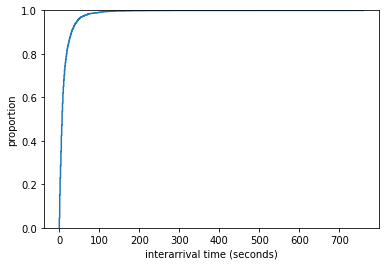

In [173]:
interarrival_times = distance_distribution(t[SUBMISSION_TIME])
sb.ecdfplot(interarrival_times)
plt.xlabel('interarrival time (seconds)')
plt.ylabel('proportion')
summary = summarize_distribution(interarrival_times)

# sanity check
assert np.absolute(summary.mean - final_submission_time / number_of_jobs) < 1

summary

## Load profiles

DistributionSummary(mean=4.6097222222222225, median=4.0, modes=array([2]), std=3.7666909926287575, mad=2.0, min_=0, p25=2.0, p75=6.0, max_=23)

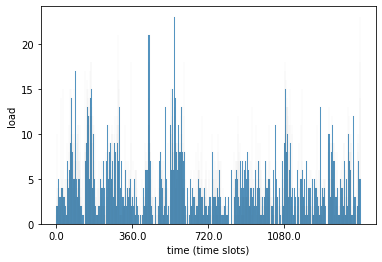

In [174]:
fig = sb.histplot(t[SUBMISSION_TIME], binwidth=DELTA)
xticks = np.round(np.linspace(0, np.round(final_submission_time / DELTA), num=4, endpoint=False))
plt.xticks(xticks * DELTA, xticks)
plt.xlabel('time (time slots)')
plt.ylabel('load')

loads = np.array([h.get_height() for h in fig.patches])
summarize_distribution(loads)

## Peak to mean ratio

In [175]:
loads.max() / loads.mean()

4.989454655016571

### Peak distance

Distance between peaks. A peak is a time slot with load greater than the 0.75-quantile.

DistributionSummary(mean=4.096866096866097, median=1.0, modes=array([[1]]), std=7.625251675395644, mad=array([0.]), min_=1, p25=1.0, p75=3.0, max_=62)

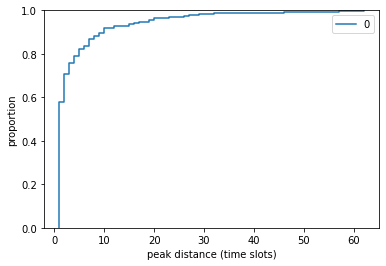

In [176]:
peaks = np.argwhere(loads > np.quantile(loads, 0.75))
peak_distances = distance_distribution(peaks)
sb.ecdfplot(peak_distances)
plt.xlabel('peak distance (time slots)')
plt.ylabel('proportion')
summarize_distribution(peak_distances)

### Valley length

Number of time slots up to each time slot with a smaller load.

DistributionSummary(mean=5.1, median=0.0, modes=array([0]), std=34.36408008371532, mad=0.0, min_=0, p25=0.0, p75=2.0, max_=876)

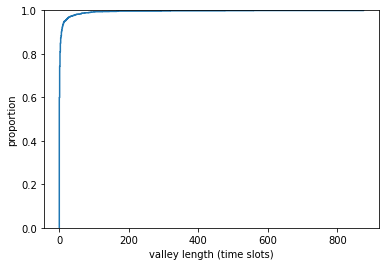

In [177]:
valley_lengths = np.array([i - (np.argwhere(loads[:i] >= loads[i]).max(initial=-1)) - 1 for i in range(loads.shape[0])])
sb.ecdfplot(valley_lengths)
plt.xlabel('valley length (time slots)')
plt.ylabel('proportion')
summarize_distribution(valley_lengths)

### Diurnal pattern

Loads follow a diurnal pattern if during every 24 hour period (excluding the first day) there is at least one time slot with a valley length greater or equals to 12 hours.

In [178]:
TIME_SLOTS_PER_DAY = floor(DELTA / (24 * 60 * 60))
if duration.d > 1:
  print(np.array([np.array([valley_lengths[i * TIME_SLOTS_PER_DAY + j] >= 12 for j in range(24)]).any() for i in range(1, floor(valley_lengths.shape[0] / TIME_SLOTS_PER_DAY))]).all())
else:
  print('trace is too short')

trace is too short


## Job duration

DistributionSummary(mean=1.0, median=1.0, modes=array([1]), std=0.0, mad=0.0, min_=1, p25=1.0, p75=1.0, max_=1)

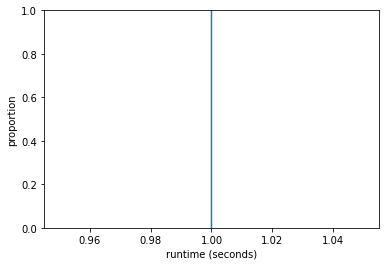

In [179]:
runtime = t[END_TIME] - t[START_TIME]
sb.ecdfplot(runtime)
plt.xlabel('runtime (seconds)')
plt.ylabel('proportion')
summarize_distribution(runtime.to_numpy())

## Scheduling rate / queueing delay

DistributionSummary(mean=0.0, median=0.0, modes=array([0]), std=0.0, mad=0.0, min_=0, p25=0.0, p75=0.0, max_=0)

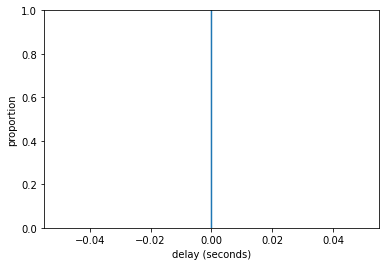

In [180]:
queueing_delay = t[START_TIME] - t[SUBMISSION_TIME]
sb.ecdfplot(queueing_delay)
plt.xlabel('delay (seconds)')
plt.ylabel('proportion')
summarize_distribution(queueing_delay.to_numpy())